# CNN Model for forecasting rainfall on yearly basis

This model has been proven to be the best when comapred to MLP, LSTM and Bi-LSTM models. 

In [1]:
# univariate multi-step vector-output 1d cnn example
from numpy import array
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd

from math import log
from math import exp
from scipy.stats import boxcox

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
# invert a boxcox transform for one value
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

### Loading the Dataset, splitting it into Train, Val and Test sets.

Here a total of 11689 samples for Training, 7580 smaples for Validation and 731 samples for training were chosen. Normalization and Box-Cox power transform were applied to make the data more Guassian and uniform.

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


data = pd.read_csv("Timeseries_real_data_interview.csv")
t = data.iloc[0:11689] #11565
v = data.iloc[11689:19269]
ts = data.iloc[19269:20001]


# define input sequence
train_seq = t['Value'].values
val_seq = v['Value'].values
test_seq = ts['Value'].values

train_seq, tr_lamb = boxcox(train_seq)
val_seq, vl_lamb = boxcox(val_seq)
test_seq, ts_lamb = boxcox(test_seq)

train_seq = train_seq.reshape((len(train_seq), 1))
val_seq = val_seq.reshape((len(val_seq), 1))
test_seq = test_seq.reshape((len(test_seq), 1))

scaler1 = scaler.fit(train_seq)
train_seq = scaler1.transform(train_seq)

scaler2 = scaler.fit(val_seq)
val_seq = scaler2.transform(val_seq)

scaler3 = scaler.fit(test_seq)
test_seq = scaler3.transform(test_seq)

print('Training Sequence : %d'%len(train_seq))
print('Validation Sequence : %d'%len(val_seq))
print('Testing Sequence : %d'%len(test_seq))

s1 = []
s2 = []
s3 = []

for i in range(len(train_seq)):
    s1.append(train_seq[i][0])
    
for i in range(len(val_seq)):
    s2.append(val_seq[i][0])
    
for i in range(len(test_seq)):
    s3.append(test_seq[i][0])
    
tr = s1
vl = s2
ts = s3

Training Sequence : 11689
Validation Sequence : 7580
Testing Sequence : 731


### Reshaping Data for the model

In [5]:
# choose a number of time steps
n_steps_in, n_steps_out = 365, 365
# split into samples
X_train, y_train = split_sequence(tr, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(vl, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(ts, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [6]:
# define model
import keras.backend as kb

def r2_score(y_true, y_pred):
    ss_res = kb.sum(kb.square(y_true - y_pred))
    ss_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - ss_res/(ss_tot + kb.epsilon()))

model = Sequential()
model.add(Conv1D(filters=126, kernel_size=2, activation='tanh', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])

### Training model for 100 epoch with a batch size of 64

In [7]:
# fit model
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/100
172/172 [==============================] - 34s 200ms/step - loss: 3.9090 - r2_score: -62.5630 - mae: 0.5647 - root_mean_squared_error: 1.0745 - val_loss: 2.6316 - val_r2_score: 0.0990 - val_mae: 0.0902 - val_root_mean_squared_error: 0.1145
Epoch 2/100
172/172 [==============================] - 32s 185ms/step - loss: 2.5337 - r2_score: -3.2332 - mae: 0.2185 - root_mean_squared_error: 0.2754 - val_loss: 2.3000 - val_r2_score: 0.0949 - val_mae: 0.0904 - val_root_mean_squared_error: 0.1145
Epoch 3/100
172/172 [==============================] - 32s 186ms/step - loss: 2.1780 - r2_score: -2.5315 - mae: 0.1994 - root_mean_squared_error: 0.2516 - val_loss: 1.9522 - val_r2_score: 0.1476 - val_mae: 0.0872 - val_root_mean_squared_error: 0.1109
Epoch 4/100
172/172 [==============================] - 32s 185ms/step - loss: 1.8243 - r2_score: -1.8020 - mae: 0.1775 - root_mean_squared_error: 0.2242 - val_loss: 1.6189 - val_r2_score: 0.3236 - val_mae: 0.0771 - val_root_mean_squared_error: 0.

### Plots of Losses and Metrics

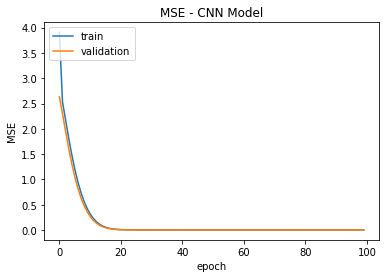

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE - CNN Model')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/yearly/loss.png')
plt.show()

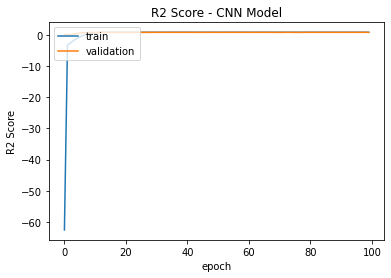

In [9]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('R2 Score - CNN Model')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/yearly/r2_score.png')
plt.show()

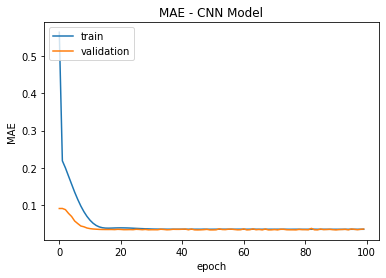

In [10]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE - CNN Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/yearly/mae.png')
plt.show()

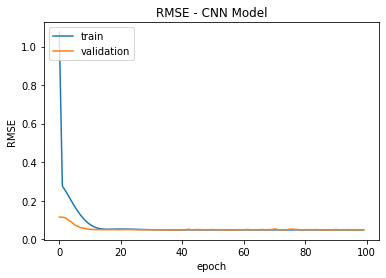

In [11]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE - CNN Model')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('saved/cnn/yearly/rmse.png')
plt.show()

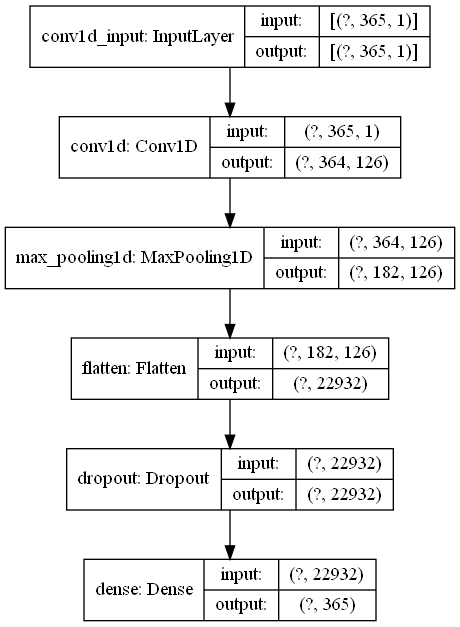

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='saved/cnn/yearly/model.png', show_shapes=True, show_layer_names=True)

### Model Summary

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 364, 126)          378       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 182, 126)          0         
_________________________________________________________________
flatten (Flatten)            (None, 22932)             0         
_________________________________________________________________
dropout (Dropout)            (None, 22932)             0         
_________________________________________________________________
dense (Dense)                (None, 365)               8370545   
Total params: 8,370,923
Trainable params: 8,370,923
Non-trainable params: 0
_________________________________________________________________
None


### Save the History of training to csv file for future references

In [14]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'saved/cnn/yearly/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Prediction

In [15]:
prediction = model.predict(X_test, verbose=0)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(prediction, y_test)
r2 = r2_score(prediction[0], y_test[0])
print('Predicted MSE : %s'%mse)
print('Predicted R2 Score : %s'%r2)

Predicted MSE : 0.003937077103047666
Predicted R2 Score : 0.866555363204479


### Prediceted Data and Test data

In [17]:
y_test[0]

array([0.36789818, 0.34743641, 0.3825204 , 0.29735674, 0.17577532,
       0.12397073, 0.15501256, 0.18574762, 0.12014088, 0.18403331,
       0.13503403, 0.08115311, 0.11345964, 0.25431382, 0.3608587 ,
       0.25768076, 0.3227951 , 0.36661672, 0.49581204, 0.57278062,
       0.49910249, 0.51117689, 0.54990121, 0.63897591, 0.56410915,
       0.55838923, 0.52168231, 0.52476997, 0.50335398, 0.40063246,
       0.48758398, 0.31316961, 0.4274981 , 0.26121162, 0.19547162,
       0.18346227, 0.07793996, 0.10001702, 0.07375497, 0.12738178,
       0.24711164, 0.10505898, 0.19549635, 0.21426514, 0.25206633,
       0.29802314, 0.33641449, 0.36966753, 0.44207564, 0.44628803,
       0.6205512 , 0.50733148, 0.69425997, 0.54877479, 0.5609825 ,
       0.5827386 , 0.52083309, 0.47372199, 0.4425659 , 0.40421694,
       0.35430204, 0.49454542, 0.2456771 , 0.27017908, 0.15826861,
       0.14612559, 0.06243957, 0.0684436 , 0.09834414, 0.06714545,
       0.02902316, 0.14547855, 0.19487005, 0.24075386, 0.34012

In [18]:
prediction[0]

array([0.40706006, 0.35704458, 0.30844194, 0.25092953, 0.20958564,
       0.17067966, 0.14570773, 0.11103557, 0.10796043, 0.10968634,
       0.12383295, 0.13541503, 0.17024249, 0.21911946, 0.25927955,
       0.3072253 , 0.34456593, 0.39382616, 0.44902986, 0.49927217,
       0.53142196, 0.56424165, 0.59272546, 0.5922364 , 0.602563  ,
       0.5808215 , 0.56478393, 0.5277958 , 0.49579233, 0.45222962,
       0.4064679 , 0.35331184, 0.3074069 , 0.24927244, 0.19974639,
       0.17066231, 0.13271382, 0.11493892, 0.09983274, 0.10234441,
       0.11989491, 0.13618402, 0.15957615, 0.20974793, 0.25473243,
       0.29669613, 0.34977812, 0.39549476, 0.44148022, 0.4928314 ,
       0.52783537, 0.55949223, 0.5747979 , 0.5950285 , 0.5952116 ,
       0.57936305, 0.5670128 , 0.5263653 , 0.48893023, 0.44771034,
       0.4036429 , 0.34920582, 0.30217898, 0.2444245 , 0.19685416,
       0.16796653, 0.12944849, 0.10123427, 0.09529491, 0.09925593,
       0.10005964, 0.12950303, 0.16864973, 0.19954705, 0.24481

## Bar graph of the Test and Predicted data

<BarContainer object of 365 artists>

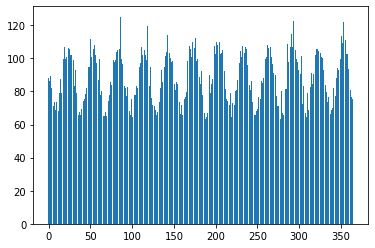

In [19]:
y_test_invert = scaler.inverse_transform(y_test)
y_test_invert
y_test_invert_final = []
# Inverse Box-Cox Transform
for i in range(len(y_test_invert[0])):
    y_test_invert_final.append(invert_boxcox(y_test_invert[0][i], ts_lamb))
x = np.arange(365)
plt.bar(x, y_test_invert_final)

<BarContainer object of 365 artists>

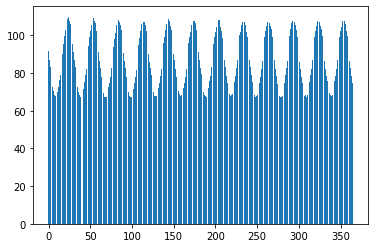

In [20]:
y_pred_invert = scaler.inverse_transform(prediction)

y_pred_invert_final = []
# Inverse Box-Cox Transform
for i in range(len(y_pred_invert[0])):
    y_pred_invert_final.append(invert_boxcox(y_pred_invert[0][i], ts_lamb))
x = np.arange(365)
plt.bar(x, y_pred_invert_final)

## Predicted MSE and R2 Score

In [24]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_pred_invert_final, y_test_invert_final)
r2 = r2_score(y_pred_invert_final, y_test_invert_final)
print('Predicted MSE : %s'%mse)
print('Predicted R2 Score : %s'%r2)

Predicted MSE : 29.27871376877458
Predicted R2 Score : 0.8597515379693244


# Yearly Forecast

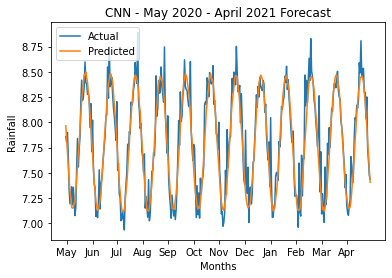

In [36]:
month_starts = [1,32,61,92,122,153,183,214,245,275,306,336]
month_names = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr'] 

fig, ax = plt.subplots()

plt.plot(y_test_invert[0])
plt.plot(y_pred_invert[0])
plt.title('CNN - May 2020 - April 2021 Forecast')
plt.ylabel('Rainfall')
plt.xlabel('Months')
ax.set_xticks(month_starts)
ax.set_xticklabels(month_names)
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.savefig('saved/cnn/yearly/test.png')
plt.show()